Asynchronous class 21: April 14, 2021
============================

Today we take our coupled acoustic/gravity wave system to a less simple non-constant system: the Eddington radiative atmosphere from early in the semester.

# Homework
No written homework.  Instead, read two things this week.
1. Chodhuri chapter 9 ("Rotation and hydrodynamics")
2. Chandrasekhar chapter 2 ("The effect of rotation")

# Lecture
1. Read [Townsend & Teitler 2013: GYRE: an open-source stellar oscillation code](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.3406T/abstract). 

2. Work through the material below.  There's a participation part at the bottom.

When are non-constant coefficient problems interesting?  Asteroseismology is a clear case, where we use oscillations to constrain and determine the internal structures of stars.   For an introduction to these ideas, I'd like you to read [Townsend & Teitler 2013: GYRE: an open-source stellar oscillation code](https://ui.adsabs.harvard.edu/abs/2013MNRAS.435.3406T/abstract) (and posted on Canvas). This paper is a good example of the material we've been learning on non-constant coeff systems, applied to actual stars, including some neat things that happen like "avoided crossings" and "mixed modes".  This paper also does an excellent job of showing how to appropriately benchmark a new computational tool, establishing both the accuracy of the numerical techniques and their computational costs.

Speaking of computation, let's play around a bit with numerical solutions to non-constant systems.  These are the backbone of most applications of linear problem techniques to interesting problems.  

This notebook will require `dedalus` and `eigentools`.  Both are installed on the RC JupyterLab, and I've tested this there.  On the JupyterLab, I have files for everyone under folder `AS21`.  You may need to move your file into your local home directory to run it successfully, based on experiences by students in the class on other exercises.  If you do this on RC's JupyterLab, download the notebook after you complete it (right click on it in the file tree to get that option), and upload that to Canvas.

\renewcommand{\vec}{\boldsymbol}
\newcommand{\del}{\vec{\nabla}}
\newcommand{\pomega}{\varpi}

Non-constant coefficient atmospheres: general cases
----------------------------------
Polytropes are nice, but what if $\kappa$ is not itself constant, and what if the physical mechanism leading to thermal equilibrium is not thermal diffusion?  In that case we need to solve a set of coupled (likely nonlinear) partial differential equations to obtain the basic state.  

Here we'll use Dedalus to solve for a system in hydrostatic and thermal balance when the processes are decidedly nonlinear.  The technique for doing this is a Nonlinear Boundary Value Problem, or `NLBVP`.  

As our target atmosphere, we will solve for an atmosphere where the thermal balance is determined by radiative transport under the Eddington Approximation, and where the opacity $\kappa$ is a (potentially non-linear) function of temperature and density. The resulting (non-dimensional) equations for hydrostatic and thermal equilbrium are:
\begin{align}
\nabla \ln T + \nabla \ln\rho &= -\frac{g^*}{T}\left(1+\kappa F\right) \\
\nabla \ln T &= -Q\frac{\rho\kappa}{T^4}
\end{align}
where $g^* = g/(L R T_c)$ determines the lengthscales $L$ of the system in terms of $g$ and a charactistic temperature $T_c$, $F$ represents radiative pressure in the atmosphere (important in astrophysical systems), and $Q$ is a non-dimensional number related to the overall optical depth of the system.  The first equation looks like our hydrostatic balance in the polytrope with a extra body force, while the second equation is fundamentally thermal balance (which we get to via $\nabla E = -\rho \kappa$ with $E \propto T^4$ the radiative energy density).

For simplicity, we'll adopt "Kramer-like" oppacities, which have a power-law dependence on T and $\rho$:
\begin{align}
\kappa \propto \rho^a T^b
\end{align}
which yields these non-dimensional equations (now in terms of $\ln T$ and $\ln \rho$ exclusively for stability reasons):
\begin{align}
\nabla\ln T + \nabla \ln \rho &= -{g^*}\left[1+F*\exp{\left(a\ln\rho+b\ln T\right)}\right]\exp{\left(-\ln T\right)}\\
\nabla \ln T &= -Q\exp{\left[(a+1)\ln\rho+(b-4)\ln T\right]}.
\end{align}
with two distinct derivatives, we'll need two boundary conditions (which set the scales for $\ln T$ and $\ln \rho$), and with that and sensible choices for $g^*$ and $Q$ we're off to the races!

This all should look familiar to you; earlier in the semester we solved for this exact equilbrium system.  Here we re-solve for that equilbrium, and then study linear waves about that background.

This example comes from the [Dedalus methods paper, Burns et al (2020), Section XI.G](https://ui.adsabs.harvard.edu/abs/2020PhRvR...2b3068B/abstract), and we'll adopt their values (and implement their [code](https://github.com/DedalusProject/methods_paper_examples/blob/master/atmospheric_waves/solve_atmosphere.py)).  What's amazing is that we can solve this crazy nonlinear system in about a second on a modern (single processor) machine.

Run the blocks of code below:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

m=1.5, m_ad = 1.4999999999999998, m_poly=(3-0)/(1+1)=1.5
Q = 0.999980911680905, 1-Q = 1.9088319095028616e-05
Target atmosphere has ln_Teff = -2 and τ0 = 3973.94 for ε = 0.000167759
2021-04-14 00:06:18,041 __main__ 0/1 INFO :: Perturbation norm: 1.159
2021-04-14 00:06:18,078 __main__ 0/1 INFO :: Perturbation norm: 1.314
2021-04-14 00:06:18,117 __main__ 0/1 INFO :: Perturbation norm: 1.337
2021-04-14 00:06:18,161 __main__ 0/1 INFO :: Perturbation norm: 1.444
2021-04-14 00:06:18,216 __main__ 0/1 INFO :: Perturbation norm: 1.646
2021-04-14 00:06:18,279 __main__ 0/1 INFO :: Perturbation norm: 1.815
2021-04-14 00:06:18,354 __main__ 0/1 INFO :: Perturbation norm: 1.84
2021-04-14 00:06:18,434 __main__ 0/1 INFO :: Perturbation norm: 1.332
2021-04-14 00:06:18,505 __main__ 0/1 INFO :: Perturbation norm: 0.3646
2021-04-14 00:06:18,577 __main__ 0/1 INFO :: Perturbation norm: 0.01208
2021-04-14 00:06:18,647 __main__ 0/1 INFO :: Perturbation norm: 5.834e-06
2021-04-14 00:06:18,718 __main__ 0/1 INFO :

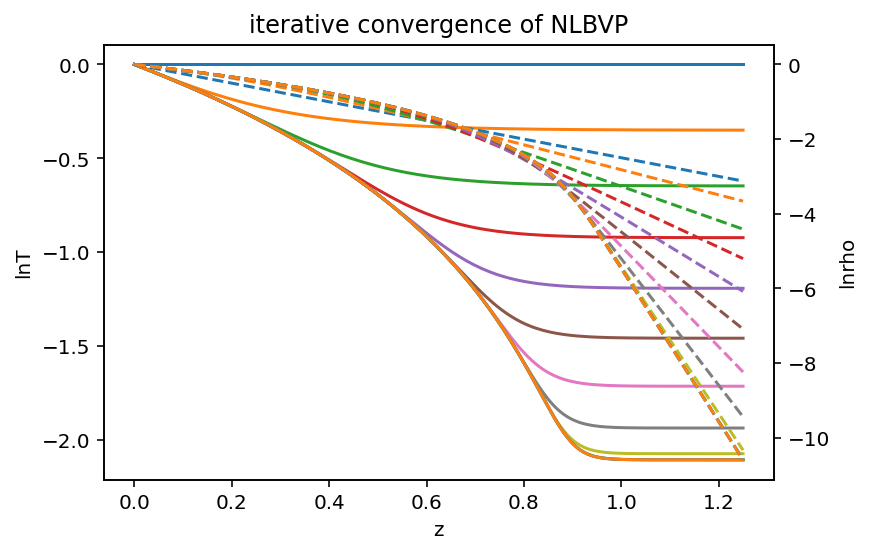

In [2]:
# settings for atmosphere
a = 1
b = 0  # -3.5 for last part of part 2

from dedalus import public as de
import time
import logging
logger = logging.getLogger(__name__)

matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)
dlog = logging.getLogger('pencil')
dlog.setLevel(logging.WARNING)
# settings for solver
ncc_cutoff = 1e-9
tolerance = 1e-8

nz = 128
F = 1e-5 # set to zero for analytic atmosphere comparison

ln_Teff = -2
f = 1/3
q = 2/3

# Derived parameters from Barekat & Brandenburg 2014
m_poly = (3-b)/(1+a)

gamma = 5/3
m_ad = 1/(gamma-1)
m = m_poly
print("m={}, m_ad = {}, m_poly=(3-{})/(1+{})={}".format(m, m_ad, b, a, m_poly))


# New Q calculation
τ0 = 4*f*np.exp(-4*ln_Teff) - q
ε = q/τ0
c6 = np.exp(ln_Teff)**4 / 4 / f
c3_c1 = c6_c4 = (1 - (c6*q)**(1+(a-b)/4)) * (1+a) / (1 + (a-b)/4)
Q = (m+1) * c3_c1 / 4
print("Q = {:}, 1-Q = {:}".format(Q, 1-Q))
c4 = c6/c6_c4
c1 = (m+1)
η = c1/c4
Lz = 1.25

print("Target atmosphere has ln_Teff = {} and τ0 = {:g} for ε = {:g}".format(ln_Teff, τ0, ε))

# Domain
#z_basis = de.Legendre('z', nz, interval=(0,Lz), dealias=2, tau_after_pre=False)
z_basis = de.Chebyshev('z', nz, interval=(0,Lz), dealias=2, tau_after_pre=False)
domain = de.Domain([z_basis], np.float64)

# Problem
problem = de.NLBVP(domain, variables=['ln_T', 'ln_rho'], ncc_cutoff=ncc_cutoff)
problem.parameters['a'] = a
problem.parameters['b'] = b
problem.parameters['g'] = g = (m+1)
problem.parameters['Lz'] = Lz
problem.parameters['gamma'] = gamma
problem.parameters['ε'] = ε
problem.parameters['η'] = η
problem.parameters['Q'] = Q
problem.parameters['F'] = F
problem.parameters['lnT0'] = lnT0 = 0
problem.parameters['lnρ0'] = lnρ0 = m*lnT0
problem.substitutions['ρκ(ln_rho,ln_T)'] = "exp(ln_rho*(a+1)+ln_T*(b))"
problem.add_equation("dz(ln_T) = -Q*exp(ln_rho*(a+1)+ln_T*(b-4))")
problem.add_equation("dz(ln_T) + dz(ln_rho) = -g*(1+F*exp(a*ln_rho+b*ln_T))*exp(-ln_T)")
problem.add_bc("left(ln_T)   = lnT0")
problem.add_bc("left(ln_rho) = lnρ0")

# Initial guess
solver = problem.build_solver()
z = domain.grid(0, scales=domain.dealias)
z_diag = domain.grid(0, scales=1)
ln_T = solver.state['ln_T']
ln_rho = solver.state['ln_rho']
ln_T.set_scales(domain.dealias)
ln_rho.set_scales(domain.dealias)

grad_ln_rho = domain.new_field()
ln_T['g'] = lnT0
grad_ln_rho['g'] = -g
grad_ln_rho.antidifferentiate('z',('left',lnρ0), out=ln_rho)

# Diagnostics
diagnostics = solver.evaluator.add_dictionary_handler(group='diagnostics')
diagnostics.add_task('1/gamma*dz(ln_T) - (gamma-1)/gamma*dz(ln_rho)',name='dsdz_Cp')
diagnostics.add_task('1/gamma*ln_T - (gamma-1)/gamma*ln_rho',name='s_Cp')
diagnostics.add_task('-ρκ(ln_rho,ln_T)*η', name='dτ')
diagnostics.add_task('dz(ln_T)/dz(ln_rho)', name='1/m')

# Iterations
pert = solver.perturbations.data
pert.fill(1+tolerance)
solver.evaluator.evaluate_group("diagnostics")
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_title("iterative convergence of NLBVP")
ax.set_xlabel('z')
iter = 0
start_time = time.time()
try:
    while np.sum(np.abs(pert)) > tolerance and np.sum(np.abs(pert)) < 1e6:
        ax.plot(z, ln_T['g'], label='lnT')
        ax.set_ylabel("lnT")
        ax2.plot(z, ln_rho['g'], label='lnrho', linestyle='dashed')
        ax2.set_ylabel("lnrho")
        solver.newton_iteration()
        logger.info('Perturbation norm: {:.4g}'.format(np.sum(np.abs(pert))))
        logger.debug('iterates:  lnρ [{:.3g},{:.3g}]; lnT [{:.3g},{:.3g}]'.format(ln_rho['g'][-1],ln_rho['g'][0], ln_T['g'][-1],ln_T['g'][0]))
        solver.evaluator.evaluate_group("diagnostics")
        iter += 1
except:
    raise
end_time = time.time()
logger.info("converged in {:d} iter and in {:g} seconds".format(iter, end_time-start_time))

The figure above shows the iterative convergence of the atmosphere, starting from the initial guess of an isothermal atmosphere (blue lines) and then showing each sucessive solution to the `NLBVP`.  The solid lines show the log temperature, while the dashed lines show the log density.  It takes about 12 iterations and about about 0.7 seconds on my machine to converge this solution (2021 M1 MacBook Pro; it took ~2x longer on my 2018 MacBook Pro).

Let's plot up some properties of the atmosphere and then solve for waves in this system.  You should recognize some of these from your plots in Asynchronous Lecture 20.  Note that here the calculation of $\omega_\mathrm{ac}$ is done a little differently than in [Gough (2007)](https://ui.adsabs.harvard.edu/abs/2007AN....328..273G/abstract).  This treatment is taken from [Hindman & Zweibel (1994)](https://ui.adsabs.harvard.edu/abs/1994ApJ...436..929H/abstract) and posted on Canvas (see their eqns 3.9, 4.1-4.3 and associated discussion).

2021-04-14 00:06:18,862 __main__ 0/1 INFO :: photosphere is near z = 0.8817769819111898 (index 162)
2021-04-14 00:06:18,863 __main__ 0/1 INFO :: ln_T_phot = -1.96, ln_T_top = -2.11 and ln_T_top - ln_T_phot = -0.145
2021-04-14 00:06:18,863 __main__ 0/1 INFO :: T_phot = 0.141, T_top = 0.122 and T_top/T_phot = 0.865
2021-04-14 00:06:18,864 __main__ 0/1 INFO :: n_rho = 10.6


Text(-0.08, 1.0, '(b)')

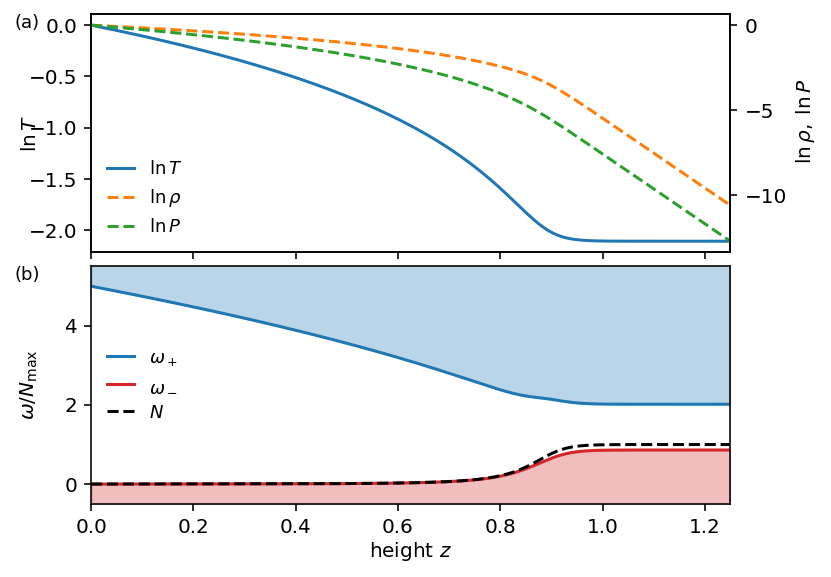

In [3]:
brunt2 = domain.new_field()
brunt2['g'] = diagnostics['dsdz_Cp']['g']*g
brunt2.set_scales(domain.dealias, keep_data=True)

Cs = domain.new_field()
Cs_z = domain.new_field()
Cs_zz = domain.new_field()
Cs.set_scales(domain.dealias)
Cs['g'] = np.sqrt(gamma)*np.exp(ln_T['g']*0.5)
Cs.differentiate('z', out=Cs_z)
Cs_z.differentiate('z', out=Cs_zz)
ω_ac2 = domain.new_field()
ω_ac2.set_scales(domain.dealias)
ω_ac2['g'] = Cs['g']*Cs_zz['g'] + gamma**2*g**2/(4*Cs['g']**2)
ω_lamb2 = domain.new_field()
ω_lamb2.set_scales(domain.dealias)
ω_lamb2['g'] = 17.5**2*Cs['g']**2
ω_plus2 = domain.new_field()
ω_plus2.set_scales(domain.dealias)
ω_minus2 = domain.new_field()
ω_minus2.set_scales(domain.dealias)
ω_plus2['g'] = ω_lamb2['g'] + ω_ac2['g']
ω_minus2['g'] = brunt2['g']*ω_lamb2['g']/(ω_lamb2['g'] + ω_ac2['g'])

dtau = domain.new_field()
tau = domain.new_field()
tau.set_scales(domain.dealias)
dtau['g'] = diagnostics['dτ']['g']
dtau.antidifferentiate('z',('right',0), out=tau)
i_tau_23 = (np.abs(tau['g']-q)).argmin()
z_phot = z[i_tau_23]
logger.info('photosphere is near z = {} (index {})'.format(z_phot, i_tau_23))
ln_T_phot = ln_T['g'][i_tau_23]
ln_T_top = ln_T.interpolate(z=Lz)['g'][0]
logger.info('ln_T_phot = {:.3g}, ln_T_top = {:.3g} and ln_T_top - ln_T_phot = {:.3g}'.format(ln_T_phot, ln_T_top, ln_T_top-ln_T_phot))
logger.info('T_phot = {:.3g}, T_top = {:.3g} and T_top/T_phot = {:.3g}'.format(np.exp(ln_T_phot), np.exp(ln_T_top), np.exp(ln_T_top-ln_T_phot)))

ln_rho_bot = ln_rho.interpolate(z=0)['g'][0]
ln_rho_top = ln_rho.interpolate(z=Lz)['g'][0]
logger.info("n_rho = {:.3g}".format(ln_rho_bot - ln_rho_top))

# Plot structure
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.subplots_adjust(left=0.12, bottom=0.12, right=0.86, top=0.97, hspace=0.06)

ax1.plot(z, ln_T['g'], label=r'$\ln \,T$', c='C0')
ax1.set_ylabel(r"$\ln \,T$")
axr = ax1.twinx()
axr.plot(z, ln_rho['g'], label=r'$\ln\,\rho$', linestyle='dashed', c='C1')
axr.plot(z, ln_rho['g']+ln_T['g'], label=r'$\ln \,P$', linestyle='dashed', c='C2')
axr.set_ylabel(r"$\ln \,\rho, \; \ln \,P$")
ax1.set_xlim([0, Lz])
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = axr.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, loc='lower left', frameon=False, fontsize=9, handlelength=1.5)

max_N2 = np.max(brunt2['g'])
ax2.plot(z, np.sqrt(ω_plus2['g']/max_N2), color='C0', label=r'$\omega_+$')
ax2.plot(z, np.sqrt(ω_minus2['g']/max_N2), color='C3', label=r'$\omega_-$')
ax2.plot(z, np.sqrt(brunt2['g']/max_N2), color='black', linestyle='dashed', label=r'$N$')
ax2.fill_between(z, np.sqrt(ω_plus2['g']/max_N2), y2=np.max(np.sqrt(ω_lamb2['g']/max_N2))+1, color='C0', alpha=0.3)
ax2.fill_between(z, np.sqrt(ω_minus2['g']/max_N2), y2=-1, color='C3', alpha=0.3)
ax2.set_ylim([-0.5, 5.5])
ax2.set_ylabel(r'$\omega/N_{\mathrm{max}}$')
ax2.set_xlabel(r'height $z$')
lines1, labels1 = ax2.get_legend_handles_labels()
legend=ax2.legend(lines1, labels1, loc='center left', frameon=False, ncol=1, fontsize=9, handlelength=1.5)
legend.get_frame().set_linewidth(0.0)

ax2.xaxis.set_label_coords(0.5, -0.15)
ax1.yaxis.set_label_coords(-0.08, 0.5)
axr.yaxis.set_label_coords(1.1, 0.55)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.text(-0.08, 1.0, "(a)", transform=ax1.transAxes, fontsize=9, va='top', ha='right')
ax2.text(-0.08, 1.0, "(b)", transform=ax2.transAxes, fontsize=9, va='top', ha='right')

Here's the final state of the equilibrium atmosphere.  

In panel (a), the log temperature (left axis, solid line), and log density and log pressure (right axis, dashed lines) are shown.  The photosphere of this system is at about z=0.9; above this point the atmosphere is nearly isothermal in structure, while below it's nearly polytropic in structure.  The temperature changes by a factor of $e^{2}\approx 7.4$, while the density changes by a factor of $e^{10.6}\approx 4 \times 10^4$ (and pressure by even more).  For the parameters we've chosen (specifically our choice of $a$ and $b$ in the opacity law), the interior is adiabatically stratified, with polytropic index $m$:
\begin{align}
    m = \frac{3-b}{1+a}
\end{align}
and you can see that our choice of $a=1$, $b=0$ leads to $m = 1.5 = 1/(\gamma-1) = m_{ad}$ for $\gamma=5/3$.

In panel (b) we plot some of the frequencies of acoustic waves ($\omega_+$, blue) and internal gravity waves ($\omega_-$, red) in this system, along with the Brunt-Vaisalla frequency (dashed black).  Waves can propage if they lie within one colored region or the other, and the region they lie in determine the type of wave.  So if the frequency of the wave lies in the red region, the internal gravity wave can propagate in the range of heights $z$ that are shaded red.  And if it lies in the blue region, it's an acoustic wave.

You can see that acoustic waves can propage much deeper (to lower $z$) than the internal gravity waves.  This is because this particular atmosphere has an adiabatic interior, and internal gravity waves are evanescent there (but acoustic waves can be propagating if at high enough frequency).  The isothermal atmosphere exterior however is a nice acoustic cavity for internal gravity waves, and they merrily propagate there.  You can also see that there's a range of frequencies (roughly $1 \lesssim \omega/N_\mathrm{max} \lesssim 2$) where no waves can propagate at all (the white region of the diagram at all heights).  This is an "evanescence" region.

Solving for waves
----------------
With our non-constant coefficient atmosphere in hand, how do we now solve for linear waves?  First, we need a linear set of equations to solve.  Here we assume that the waves follow ideal (non-diffusive), fully compressible dynamics:
\begin{gather}
\frac{\partial}{\partial t} \vec{u} + \vec{\nabla}R T_1 + R T_1 \vec{\nabla}\ln \rho_0 + R T_0 \vec{\nabla}\ln \rho_1  = 0 \\
\frac{\partial}{\partial t} T + (\gamma-1)T_0\vec{\nabla}\cdot\vec{u} + \vec{u}\cdot\vec{\nabla} T_0 = 0 \\
\frac{\partial}{\partial t} \ln \rho_1 +  \vec{\nabla}\cdot\vec{u} +  \vec{u}\cdot\vec{\nabla} \ln\rho_0 = 0
\end{gather}
just like from our isothermal atmosphere acoustic-gravity waves system.  This will be a reasonable approximation if our waves are oscillating faster than radiative processes can act.

Now $T_0$, $\nabla T_0$ and $\nabla \ln \rho_0$ come from the solution to our `NLBVP` and are clearly not constant coefficients.  What do we do?

We can solve these by taking the modal solution in time
\begin{align}
    \vec{x} = [\vec{u}, T_1, \ln\rho_1] \propto e^{i \omega t},
\end{align}
and treating our linear system as an eigenvalue problem:
\begin{align}
    L\cdot\vec{x} = \lambda \vec{x}
\end{align}
where the eigenvalues $\lambda = i \omega$ are our frequencies $\omega$ coming from the time derivatives, and the $L$ operator are all of the other linear terms in our equations.  This is an EigenValue Problem (`EVP`) and we can solve it for a single horizontal wave number $k$

Eigentools
---------

Numerical eigenvalue problems are challenging and fraught with numerical error.  To do this right, we're going to pull in a package called [Eigentools](https://github.com/DedalusProject/eigentools) which performs best practices for solving eigenvalue problems by solving them on two different grids and rejecting numerically spurious solutions by comparing between the two solutions.  You can read more about this technique in Boyd (2000) "Chebyshev and Fourier Spectral Methods", chapter 7; Eigentools itself is [under review](https://github.com/openjournals/joss-reviews/issues/3079) at JOSS [(Oishi et al 2021)](https://github.com/openjournals/joss-papers/blob/joss.03079/joss.03079/10.21105.joss.03079.pdf).

Eigentools can be pip installed; I've done this in our shared RC Dedalus stack.
```
pip install eigentools
```
If you already have dedalus installed, you're now ready to run.

In [4]:
from eigentools import Eigenproblem
import eigentools

Solving for the waves at given kx
---------------------------------------

Make sure both of the commands above run correctly before proceeding.  Then run the code block below to solve for all eigenvalues at a given fixed horizontal wave number $k$.  This will take about 15 seconds to run at `nz=128`, and about 2 min to run if you go to `nz=256`.

2021-04-14 00:06:19,363 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2021-04-14 00:06:19,364 __main__ 0/1 INFO :: data nz (128) is 0.5 times larger than wave nz (256)
2021-04-14 00:06:19,384 __main__ 0/1 INFO :: max Brunt is |N| = 4.530940779455921 and  k_Hρ is 0.7500220300694197
2021-04-14 00:06:42,789 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2021-04-14 00:07:58,672 __main__ 0/1 INFO :: k=17.5 ; 305 good eigenvalues among 5 fields (23.8281%)
total time for solution: 99.388480 sec


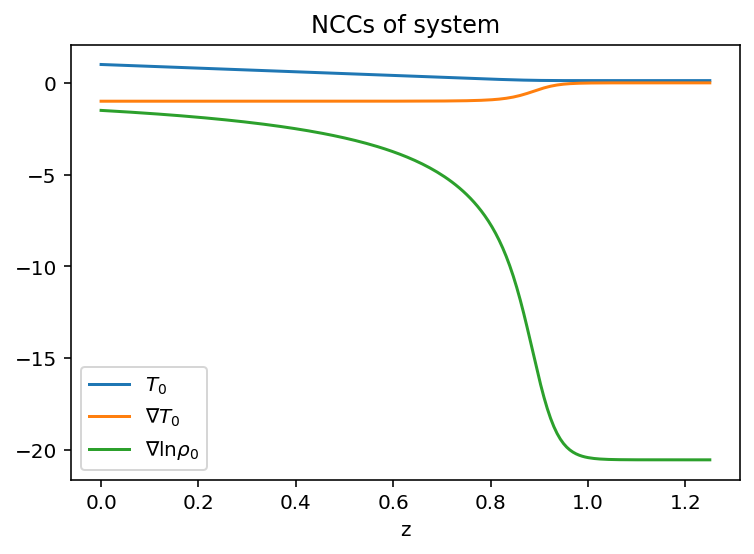

In [5]:
# horizontal wave number k to solve at
k = 17.5

# Parameters
nz_waves = 256
ncc_cutoff = 1e-9

# Problem
gamma = 5/3
#z_basis = de.Legendre('z', nz_waves, interval=(0, Lz), tau_after_pre=False)
z_basis = de.Chebyshev('z', nz_waves, interval=(0, Lz), tau_after_pre=False)
domain_EVP = de.Domain([z_basis])
waves = de.EVP(domain_EVP, ['u','w','T1','ln_rho1', 'w_z'], eigenvalue='omega', ncc_cutoff=ncc_cutoff)
n_var = 5
T0 = domain_EVP.new_field()
T0_z = domain_EVP.new_field()
ln_rho0 = domain_EVP.new_field()
del_ln_rho0 = domain_EVP.new_field()

# Resample background
scale = nz/nz_waves
logger.info("data nz ({:d}) is {} times larger than wave nz ({:d})".format(nz,scale,nz_waves))
T0.set_scales(scale)
T0_z.set_scales(scale)
ln_rho0.set_scales(scale)
del_ln_rho0.set_scales(scale)
ln_T.set_scales(1)
ln_rho.set_scales(1)
T0['g'].real = np.exp(ln_T['g'])
T0.differentiate('z', out=T0_z)
ln_rho0['g'] = ln_rho['g']
ln_rho0.differentiate('z', out=del_ln_rho0)
T0.set_scales(1, keep_data=True)
T0_z.set_scales(1, keep_data=True)
ln_rho0.set_scales(1, keep_data=True)
del_ln_rho0.set_scales(1, keep_data=True)

z = domain_EVP.grid(0)
fig, ax = plt.subplots()
ax.plot(z, T0['g'], label=r'$T_0$')
ax.plot(z, T0_z['g'], label=r'$\nabla T_0$')
ax.plot(z, del_ln_rho0['g'], label=r'$\nabla \ln \rho_0$')
ax.legend()
ax.set_title("NCCs of system")
ax.set_xlabel('z')

waves.parameters['T0'] = T0
waves.parameters['T0_z'] = T0_z
waves.parameters['del_ln_rho0'] = del_ln_rho0
waves.parameters['gamma'] = gamma
waves.parameters['k'] = 1
waves.substitutions['dt(A)'] = '1j*omega*A'
waves.substitutions['dx(A)'] = '-1j*k*A'
waves.substitutions['Div_u'] = 'dx(u) + w_z'
logger.debug("Setting z-momentum equation")
waves.add_equation("dt(w) + dz(T1) + T0*dz(ln_rho1) + T1*del_ln_rho0 = 0 ")
logger.debug("Setting x-momentum equation")
waves.add_equation("dt(u) + dx(T1) + T0*dx(ln_rho1)                  = 0 ")
logger.debug("Setting continuity equation")
waves.add_equation("dt(ln_rho1) + w*del_ln_rho0 + Div_u  = 0 ")
logger.debug("Setting energy equation")
waves.add_equation("dt(T1) + w*T0_z + (gamma-1)*T0*Div_u = 0 ")
waves.add_equation("dz(w) - w_z = 0 ")
waves.add_bc('left(w) = 0')
waves.add_bc('right(w) = 0')

# value at top of atmosphere in isothermal layer
brunt_max = np.max(np.sqrt(np.abs(brunt2['g']))) # max value in atmosphere
k_Hρ = -1/2*del_ln_rho0.interpolate(z=0)['g'][0].real
c_s = np.sqrt(T0.interpolate(z=0)['g'][0].real)
c_s2 = gamma*T0.interpolate(z=0)['g'][0].real

logger.info("max Brunt is |N| = {} and  k_Hρ is {}".format(brunt_max, k_Hρ))
start_time = time.time()
EP = Eigenproblem(waves)

eigenfunctions = {'w':[], 'u':[], 'T':[]}
omega = {'ω_plus_min':[], 'ω_minus_max':[]}

KE = domain_EVP.new_field()
rho0 = domain_EVP.new_field()
rho0['g'] = np.exp(ln_rho0['g'])
rho0_avg = (rho0.integrate('z')['g'][0]/Lz).real
logger.debug("aveage ρ0 = {:g}".format(rho0_avg))


ω_lamb2 = k**2*c_s2
ω_plus2 = ω_lamb2 + ω_ac2
ω_minus2  = brunt2*ω_lamb2/(ω_lamb2 + ω_ac2)
omega['ω_plus_min'].append(np.min(np.sqrt(ω_plus2)))
omega['ω_minus_max'].append(np.max(np.sqrt(ω_minus2)))
EP.EVP.namespace['k'].value = k
EP.EVP.parameters['k'] = k
EP.solve()
EP.reject_spurious()
ω = EP.evalues_good

logger.info("k={:g} ; {:d} good eigenvalues among {:d} fields ({:g}%)".format(k, EP.evalues_good_index.shape[0], n_var, EP.evalues_good_index.shape[0]/(n_var*nz_waves)*100))
for ikk, ik in enumerate(EP.evalues_good_index):
    EP.solver.set_state(ik)
    w = EP.solver.state['w']
    u = EP.solver.state['u']
    T = EP.solver.state['T1']


    i_max = np.argmax(np.abs(w['g']))
    phase_correction = w['g'][i_max]
    w['g'] /= phase_correction
    u['g'] /= phase_correction
    T['g'] /= phase_correction

    KE['g'] = 0.5*rho0['g']*(u['g']*np.conj(u['g'])+w['g']*np.conj(w['g'])).real
    KE_avg = (KE.integrate('z')['g'][0]/Lz).real
    weight = np.sqrt(KE_avg/(0.5*rho0_avg))

    eigenfunctions['w'].append(np.copy(w['g'])/weight)
    eigenfunctions['u'].append(np.copy(u['g'])/weight)
    eigenfunctions['T'].append(np.copy(T['g'])/weight)

end_time = time.time()
print("total time for solution: {:f} sec".format(end_time-start_time))

freqs = []
freqs.append(ω)

Now let's plot the frequencies and the vertical velocity eigenfunctions.  These reproduce a subset of Figures 16 and 17 in [Burns et al (2020), Section XI.G](https://ui.adsabs.harvard.edu/abs/2020PhRvR...2b3068B/abstract):

In [6]:
# compute frequency diagrams over a wide range of possible k
k_set = np.logspace(-1, 2, num=20) * k_Hρ
ω_lamb2 = k_set**2*np.expand_dims(Cs['g']**2, axis=1)
ω_plus2 = ω_lamb2 + np.expand_dims(ω_ac2['g'], axis=1)
ω_minus2  = np.expand_dims(brunt2['g'],axis=1)*ω_lamb2/(ω_lamb2 + np.expand_dims(ω_ac2['g'], axis=1))

# Normalize frequencies
brunt = np.sqrt(max_N2)
ω_upper = np.min(np.sqrt(ω_plus2)) / brunt
ω_lower = np.max(np.sqrt(ω_minus2)) / brunt

ω_upper_set = np.min(np.sqrt(ω_plus2),axis=0) / brunt
ω_lower_set = np.max(np.sqrt(ω_minus2),axis=0) / brunt

ω = freqs[0].real/ brunt
i_sort = np.argsort(ω)
ω = ω[i_sort]
P = 1 / ω

ks = np.array([k]*len(ω))

pad = 1.05

gwaves = (np.abs(ω) <= ω_lower*pad) * (np.abs(ω) > 0)
f_mode = (np.abs(ω) <= ω_upper) * (np.abs(ω) > ω_lower*pad)
acoustic = (np.abs(ω) > ω_upper)

# Frequency parameters
c_acoustic = 'C0'
c_gravity = 'C3'
c_f_mode = 'k'
marker = 'x'
ms = 3
mew = 0.5
freq_props = dict(marker=marker, ms=ms, mew=mew, linestyle='none', zorder=2)

Eigenfunctions for kx = 13.1254 (17.5 $k_{H\rho}$)
   ω/N, N/ω
gw 0.9, 1.1
ac 2.1, 0.5
gw 0.6, 1.8
ac 2.9, 0.3
gw 0.1, 9.6
ac 7.8, 0.1


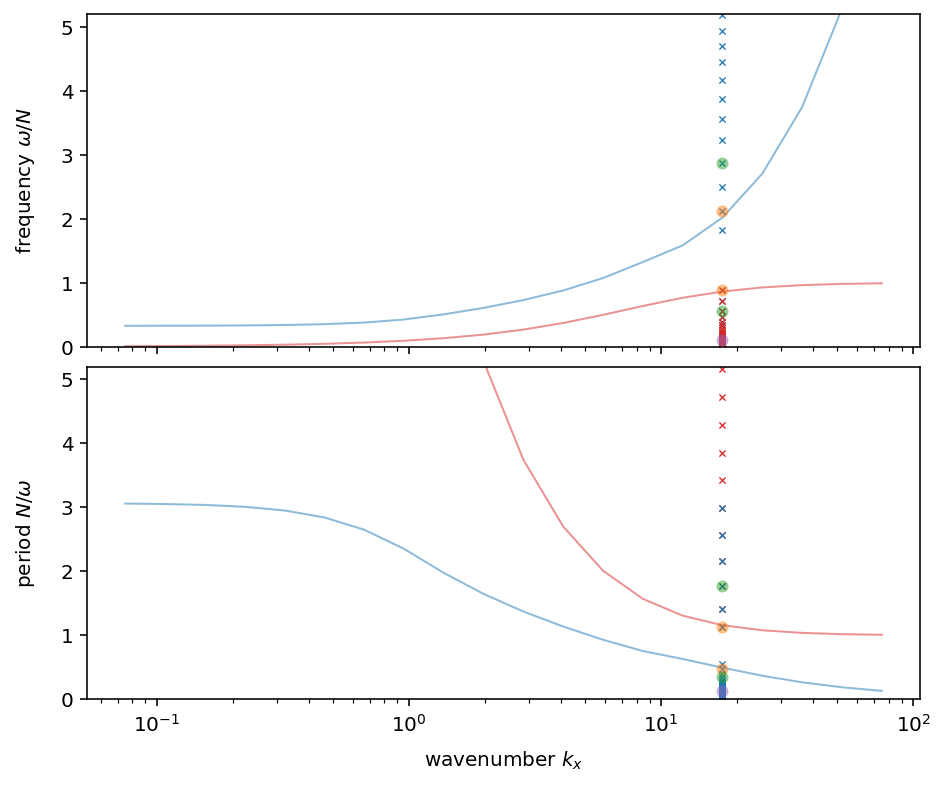

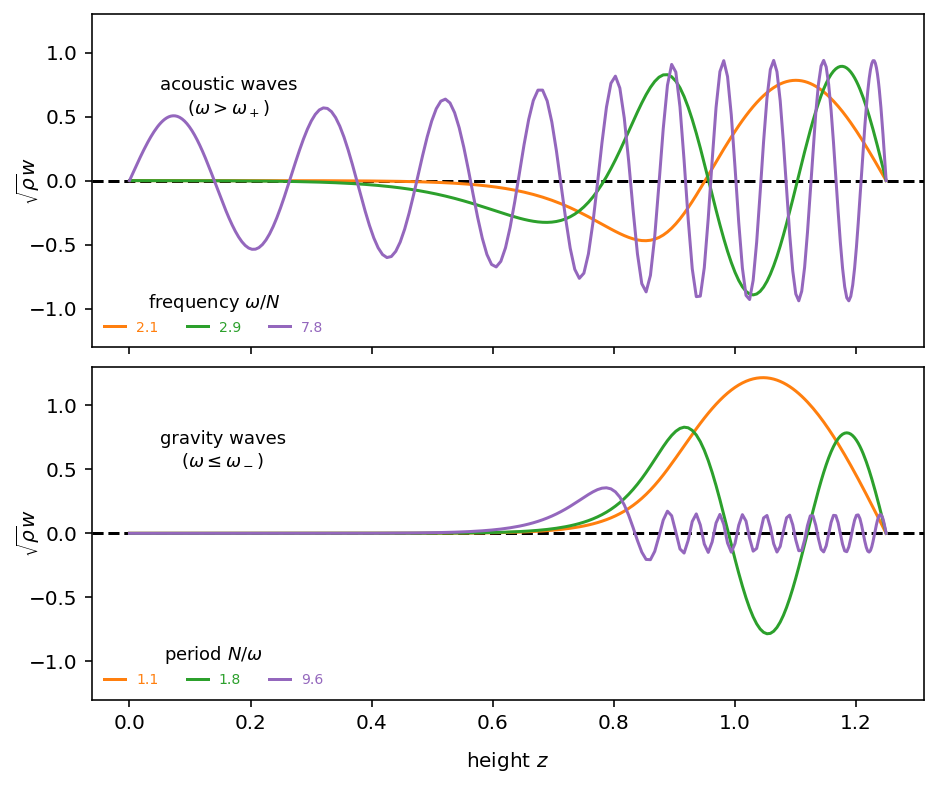

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(2*3.4, 2*2.8))
fig_eig, ax_eig = plt.subplots(nrows=2, sharex=True, figsize=(2*3.4, 2*2.8))
fig.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=0.97, hspace=0.06)
fig_eig.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=0.97, hspace=0.06)

# Plot frequencies
ax[0].plot(ks[acoustic], np.abs(ω[acoustic]), color=c_acoustic, label='ac', **freq_props)
ax[0].plot(ks[f_mode], np.abs(ω[f_mode]), color=c_f_mode, label='f', **freq_props)
ax[0].plot(ks[gwaves], np.abs(ω[gwaves]), color=c_gravity, label='ac', **freq_props)
ax[1].plot(ks[gwaves], np.abs(1/ω[gwaves]), color=c_gravity, label='gw', **freq_props)
ax[1].plot(ks[f_mode], np.abs(1/ω[f_mode]), color=c_f_mode, label='f', **freq_props)
ax[1].plot(ks[acoustic], np.abs(1/ω[acoustic]), color=c_acoustic, label='ac', **freq_props)
line_props = {'ls': 'solid', 'lw': 1, 'alpha': 0.5, 'zorder': 1}
ax[0].plot(k_set, ω_lower_set, color=c_gravity, label=r'$\omega_-$', **line_props)
ax[0].plot(k_set, ω_upper_set, color=c_acoustic, label=r'$\omega_+$', **line_props)
ax[1].plot(k_set, 1/ω_lower_set, color=c_gravity, label=r'$\omega_-$', **line_props)
ax[1].plot(k_set, 1/ω_upper_set, color=c_acoustic, label=r'$\omega_+$', **line_props)

ax_eig[0].axhline(y=0, color='black', linestyle='dashed', zorder=1)
ax_eig[1].axhline(y=0, color='black', linestyle='dashed', zorder=1)

print('Eigenfunctions for kx = {:g} ({:g} '.format(k*k_Hρ, k)+r'$k_{H\rho}$)')

# Pick modes
i_brunt = np.argmin(np.abs(P-1/ω_lower*pad))
w = np.array(eigenfunctions['w'])[i_sort,:]
u = np.array(eigenfunctions['u'])[i_sort,:]
T = np.array(eigenfunctions['T'])[i_sort,:]

gws = [0, -2, -20]
acs = [2, 4, 20]
weight = np.sqrt(rho0['g'])

# Mode properties
colors = ['C1', 'C2', 'C4', 'C5']
marker = 'o'
msc = 6
mec = "none"
print("   ω/N, N/ω")
mode_props = dict(marker=marker, mec=mec, markersize=msc, alpha=0.5, zorder=3)

for i, (gw, ac) in enumerate(zip(gws,acs)):
    igw = i_brunt + gw
    iac = i_brunt + ac
    print("gw {:3.1f}, {:3.1f}".format(ω[igw], 1/ω[igw]))
    print("ac {:3.1f}, {:3.1f}".format(ω[iac], 1/ω[iac]))
    # Plot modes
    ax_eig[0].plot(z, weight*w[iac,:].real, color=colors[i], label='{:3.1f}'.format(ω[iac]))
    ax_eig[1].plot(z, weight*w[igw,:].real, color=colors[i], label='{:3.1f}'.format(1/ω[igw]))
    # Highlight frequencies
    mode_props['color'] = colors[i]
    ax[0].plot(k, ω[igw], **mode_props)
    ax[0].plot(k, ω[iac], **mode_props)
    ax[1].plot(k, P[igw], **mode_props)
    ax[1].plot(k, P[iac], **mode_props)

    # Labels
ax[0].set_ylabel(r'frequency $\omega/N$')
ax[0].set_ylim(0, 5.2)
ax[0].set_xscale('log')
ax[1].set_xlabel(r'wavenumber $k_x$')
ax[1].set_ylabel(r'period $N/\omega$')
ax[1].set_ylim(0, 5.2)
ax[1].set_xscale('log')
ax[1].xaxis.set_label_coords(0.5, -0.15)
ax[0].yaxis.set_label_coords(-0.06, 0.5)
ax[1].yaxis.set_label_coords(-0.06, 0.5)

ax_eig[0].set_ylabel(r'$\sqrt{\rho}w$')
ax_eig[1].set_ylabel(r'$\sqrt{\rho}w$')
ax_eig[1].text(0.05, 0.65, 'gravity waves\n'+r'($\omega \leq \omega_-$)', verticalalignment='center', multialignment='center', fontsize=9)
ax_eig[0].text(0.05, 0.65, 'acoustic waves\n'+r'($\omega > \omega_+$)', verticalalignment='center', multialignment='center', fontsize=9)
ax_eig[1].set_xlabel(r'height $z$')
ax_eig[0].set_ylim(-1.3, 1.3)
ax_eig[1].set_ylim(-1.3, 1.3)
ax_eig[1].xaxis.set_label_coords(0.5, -0.15)
ax_eig[0].yaxis.set_label_coords(-0.06, 0.5)
ax_eig[1].yaxis.set_label_coords(-0.06, 0.5)

legend = ax_eig[1].legend(frameon=False, title=r'period $N/\omega$', loc='lower left', ncol=3, fontsize=7, handlelength=1.5)
plt.setp(legend.get_title(),fontsize=9)
for line,text in zip(legend.get_lines(), legend.get_texts()):
    text.set_color(line.get_color())
legend = ax_eig[0].legend(frameon=False, title=r'frequency $\omega/N$', loc='lower left', ncol=3, fontsize=7, handlelength=1.5)
plt.setp(legend.get_title(),fontsize=9)
for line,text in zip(legend.get_lines(), legend.get_texts()):
    text.set_color(line.get_color())

# Participation

1. Observe the eigenfunction figures above.  The wave length of the acoustic waves (top panel) for each mode (individual colored line) can be estimated by visually measuring the spacing between subsequent nodes.  What can you say about the wavelength of the acoustic modes in the deep part of the atmosphere ($z<0.75$), where the atmosphere is nearly polytropic and the coefficients are non-constant, versus the upper portion of the atmosphere ($z>0.75$) where the atmosphere is nearly isothermal and the coefficients are constant?

2. Why are the internal gravity waves trapped in an acoustic cavity in the region $z>0.75$?

3. Go to the very top of this notebook, and change the radiation coefficients in the "solving for the atmosphere" portion to `a=1`, `b=-3.5`.  Re-run all of the cells of the notebook.  What happens to the eigenfunctions of the internal gravity waves?  Given the arguments you made in part 1 of this exercise, and given the definition of $m$ in terms of $a$ and $b$, argue why the internal gravity waves are now able to span the entire atmosphere.

4. The highest frequency acoustic waves and the lowest frequency (highest period) gravity waves are the most contaminated by numerical error.  Based on what you see in the eigenfunctions, why do you think that is?

5. In isothermal atmospheres, we learned that the kinetic energy of waves is approximately constant in height, if you average across a wave cycle.  Is that approximately true here?  Show this with a plot.  Here's how to compute the kinetic energy of the eigenfunctions above, for some chosen wave modes `igw` and `iac` (as in the above code):
```
KE_G = rho0['g']*(u[igw,:]*np.conj(u[igw,:])+w[igw,:]*np.conj(w[igw,:])).real
KE_A = rho0['g']*(u[iac,:]*np.conj(u[iac,:])+w[iac,:]*np.conj(w[iac,:])).real
```
**To Turn in**:
Send Ben your answers to 1-5 via Canvas, uploading to Asynchronous Lecture 21.  You can do that in this ipynb and upload as an ipynb.  You can also export to PDF if you prefer.  If you do this on RC's JupyterLab, download the notebook after you complete it, and upload that to Canvas.  Please send by midnight, Thursday April 15.